The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l

# Concise Implementation of Multilayer Perceptrons
:label:`sec_mlp_concise`

As you might expect, by relying on the high-level APIs,
we can implement MLPs even more concisely.


In [2]:
from d2l import torch as d2l
import torch
from torch import nn

## Model

<center><img src="https://git.wur.nl/koots006/wias-course-image-and-video-analysis/-/raw/main/day3/classification_network_784_256_10.png" width=400></center>

We again are going to build the network depicted above.

* Using `nn.Sequential()`, we can put together the different layers and activation functions that we want to use to create the network
* `nn.Flatten()` changes the 2D image to a 1D vector input
* `nn.Linear(nr_in, nr_out)` creates a layer with `nr_out` neurons, getting input from `nr_in` elements in the previous layer.
* `nn.ReLU()` applies the ReLU activation function to the output of the previsou layer.

To initialize the weights with small random numbers, we apply the function `init_weights`, which draws random numbers from a normal distribution with a standard deviation of 0.01.

**Exercise:**
* Study the code below
* Run the code to define and initialize the network



## Model

As compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully-connected layers
(previously, we added *one*).
The first is our hidden layer,
which contains 256 hidden units
and applies the ReLU activation function.
The second is our output layer.


In [3]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

The training loop is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


In [4]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=lr)

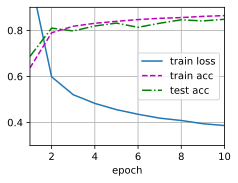

In [5]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [6]:
acc_test = d2l.evaluate_accuracy(net, test_iter)
print("The accuracy on the test set is: ", acc_test)

The accuracy on the test set is:  0.8483


## Summary

* Using high-level APIs, we can implement MLPs much more concisely.
* For the same classification problem, the implementation of an MLP is the same as that of softmax regression except for additional hidden layers with activation functions.

## Exercises

We will experiment with a number of hyperparameters (network architecture, learning rate, batch size)


1. Try adding different 1 or 2 extra hidden layers with 256 neurons per layer. What setting (keeping other parameters and hyperparameters constant) works best? <br>
NB. If you have two hidden layers with both 256 neurons, think about the number of weights you need between these two layers.

2. How does changing the learning rate alter your results? Fixing the model architecture and other hyperparameters (including number of epochs), what learning rate gives you the best results? (Note: try with a learning rate of 1 and 0.0001)

3. Try out different activation functions (relu, sigmoids, tanh). Which ones work best?
You see that the results might change depending on the hyperparameter setting. This is an important aspect of working with neural networks. Obviously, we want to deal with all hyperparameters at the same time.

4. Describe why it is much more challenging to deal with multiple hyperparameters. 

5. Think of a strategy to optimize over all the parameters (learning rate, iterations, number of hidden layers, number of hidden units per layer) jointly? 

## The XOR problem
The XOR or Exclusive OR problem has been an historical problem in the Neural Networks field. It can be defined as follows: given 2 inputs `x1` and `x2`, the output `y` will be true only when just one of the inputs is true. The following table exemplifies it:

| x1  | x2  | y   |
| --- | --- | --- |
| 0   | 0   | 0   |
| 0   | 1   | 1   |
| 1   | 0   | 1   |
| 1   | 1   | 0   | 

The next block creates a Pytorch dataset class which generates a XOR data distribution.


In [7]:
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

# A dataset class for the tomato spectra dataset
class XORDataset(Dataset):
    """
    Dataset class used to create a XOR distribution.
    It inherits the torch.utils.data.Dataset class. For more info about writing custom datasets classes check this [post](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

    Parameters
    ----------
    size : size of the dataset
    noise : represent the random noise on the data, the larger it is the more noise the data will have
    """

    def __init__(self, size=50, noise=0.5):
        x1 = np.array([0., 0., 1., 1.], dtype = np.float32)
        x2 = np.array([0., 1., 0., 1.], dtype = np.float32)
        y  = np.array([0, 1, 1, 0], dtype = np.int32)

        x1 = np.repeat(x1, size)
        x2 = np.repeat(x2, size)
        self.y =  np.repeat(y,  size)

        # Add noise to data points just to have some data variety
        self.x1 = x1 + np.random.rand(x1.shape[0])*noise
        self.x2 = x2 + np.random.rand(x2.shape[0])*noise

        # Shuffle
        index_shuffle = np.arange(self.x1.shape[0])
        np.random.shuffle(index_shuffle)

        self.x1 = self.x1[index_shuffle]
        self.x2 = self.x2[index_shuffle]
        self.y  = self.y [index_shuffle]

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        data = torch.tensor([self.x1[idx], self.x2[idx]], dtype=torch.float32)
        label = torch.tensor(self.y[idx], dtype=torch.int64)
        return data, label

    def get_all(self):
        return self.x1, self.x2, self.y

Let's create a random XOR distribution using the `XORDataset` class and see how it looks like.

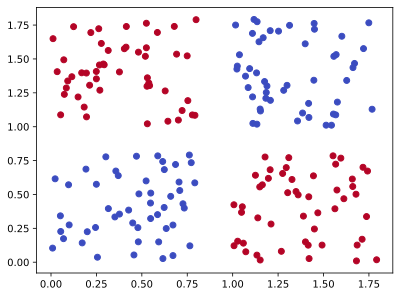

In [8]:
dataset = XORDataset(noise=0.8)
x1, x2, y = dataset.get_all()
plt.scatter(x1, x2, c=y, cmap=plt.cm.coolwarm)

**Exercise 6:** What happens in the graph if you set `noise` to 0?

Run the next code block to get a function to train a model for this XOR data and to plot the results:

In [9]:
# Let's adapt a previously defined training function (we change ylim in animator)
def train_XOR(net, train_iter, test_iter, loss, num_epochs, updater):
    """Train a model (similar to the one defined in Chapter 3)."""
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = d2l.train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics


# Let's create a function to plot the decision boundary of a model
def plot_with_decision_boundary(model, X, y):
    model.eval()
    h = .01  # step size in the mesh

    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    Z = []
    for i, j in zip(xx.ravel(), yy.ravel()):
        x_ = torch.tensor([i, j], dtype=torch.float32)
        y_hat = net(x_)
        Z.append(y_hat.argmax().detach().cpu().numpy())
    Z = np.array(Z)
    Z = np.rint(Z)

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.7)
    plt.axis('off')

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)



**Exercise 7:** 

Use and complete the following code (marked with `TODO`) to create, train and observe the results. Note
* Create a training and testset using `XORDataset(size, noise=0.8)` where you set `size` to 80 for the training set and to 20 for the test set.
* Define the architecture of our network. Note that your network should have two output nodes, since we have two classes
* Make sure to randomly initialize the weights in the network using a normal distribution with standard deviation of 0.02


Test different network architectures:
1. A perceptron
2. A MLP with 1 hidden layer and 16 hidden neurons. Use ReLU activation after the hidden layer.
3. Remove the ReLU activation, can the problem be solved now?
4. Initiate the weights to a constant value instead of a random value. You can use the function `nn.init.constant_` (see [documentation](https://pytorch.org/docs/stable/nn.init.html). What happens now?



In [10]:
# Defining some parameters
batch_size, lr, num_epochs = 16, 0.006, 100

# Creating dataset and dataloaders
### TODO: ADD YOUR CODE HERE (~2 lines), using the function XORDataset(size, noise)
train_dataset = ..
test_dataset = ..

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=2)

SyntaxError: invalid syntax (3631052331.py, line 6)

In [ ]:
# Let's define the architecture of our network.
# Note that your network should have two output node, since we have two classes

### TODO: ADD YOUR CODE HERE (~1 line) to define a network
net = ..

# Init weights
def init_weights(m):
    if type(m) == nn.Linear:
        ### TODO: ADD YOUR CODE HERE (~1 line)

net.apply(init_weights)
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss()

In [ ]:
# Train
train_XOR(net, train_loader, test_loader, loss, num_epochs, trainer)

In [ ]:
# Plot results in test set with decision boundary
x1, x2, y = test_dataset.get_all()
X = np.vstack((x1,x2)).T
plot_with_decision_boundary(net, X, y)